# Load modules and data

In [14]:
import sys
sys.path.append('../scripts')
import data_loader
import viz_tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

data = data_loader.load('../test_data.h5')     # pull sample of 5000 experiments
target = np.squeeze(data['target'][:])              # grab the target-data for each
momentum = target[:,1:3]                            # momentum target
ecal = data['ECAL'][:]                              # ecal data
total_energy = np.array([np.array(ecal[j,:,:,:].sum()) for j in range(ecal.shape[0])]) # total energy per trail

# Functions to unroll cube and plot unrolled 'windowshade'

In [49]:
def unroll_cube(cube):
    '''
    unrolls a cube like a window shade, so that the center is at the top
    spiralling outward from there into a sheet
    currently only works with a rectangular prism; 
    no irregular rectangular prisms where height != width
    
    args:
        cube: np.array of shape (width,height,depth), where width=height
    returns:
        np.array of shape (width**2,depth)
    '''
    width,height,depth = cube.shape
    unrolled = np.zeros((width**2,depth))
    half = (width-1)/2
    
    x = y = 0
    dx = 0
    dy = -1
    for i in range(width**2):

        #record rod
        unrolled[i,:]= cube[x+half,y+half,:]

        #if a corner is reached, turn
        if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
            dx, dy = -dy, dx

        #move x and y one unit    
        x, y = x+dx, y+dy
    
    windowshade = np.array(unrolled)
    assert windowshade.shape == (cube.shape[0]*cube.shape[1],cube.shape[2])
    return windowshade

In [16]:
def plot_windowshade(shade):
    plt.figure(figsize=(20,4))
    plt.imshow(shade, interpolation=None,cmap='spectral')
    plt.colorbar()
    plt.show()

# Plot a few readings from the ecal test data

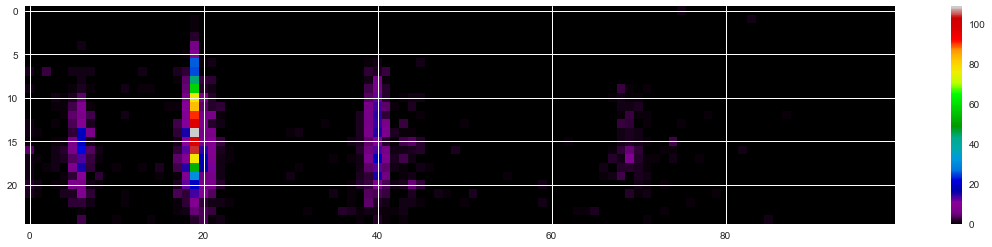

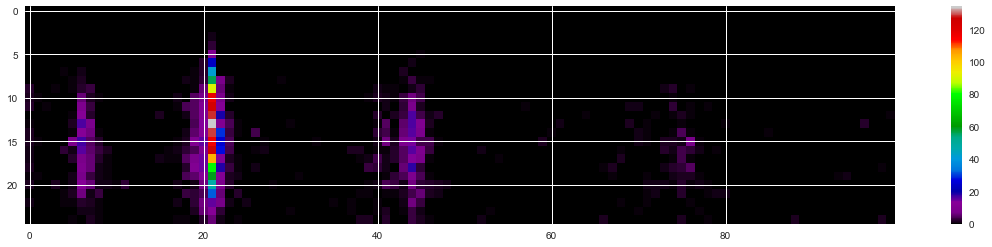

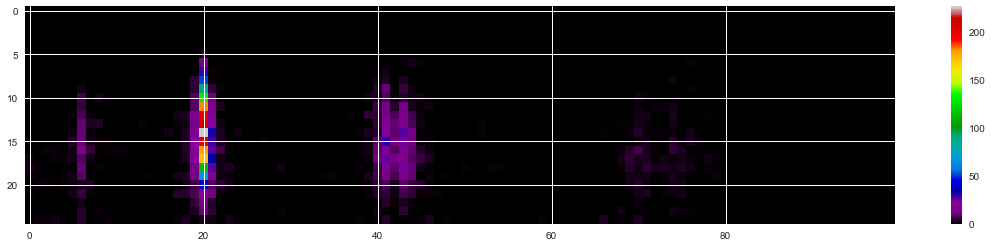

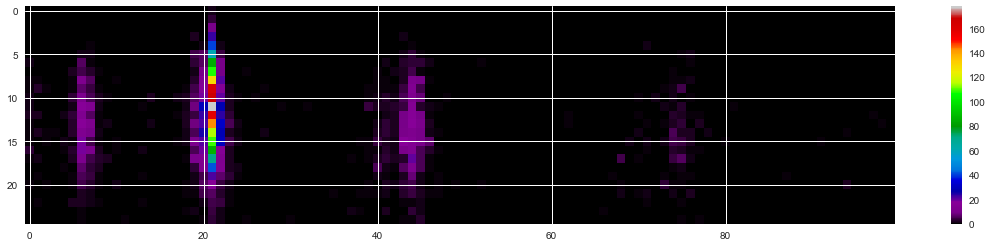

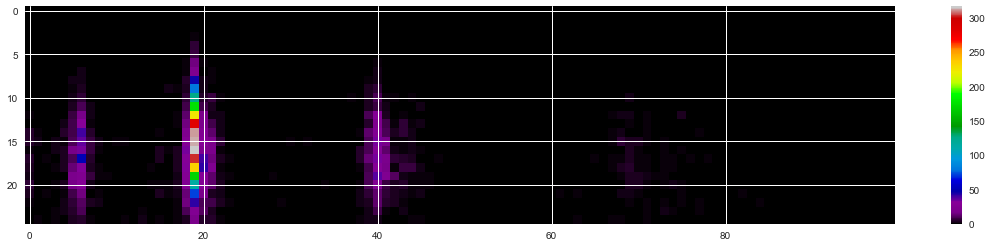

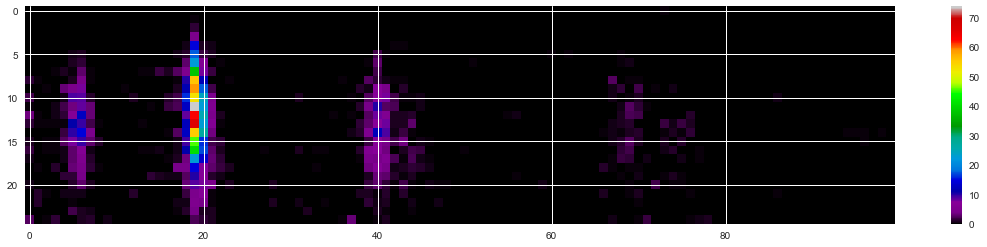

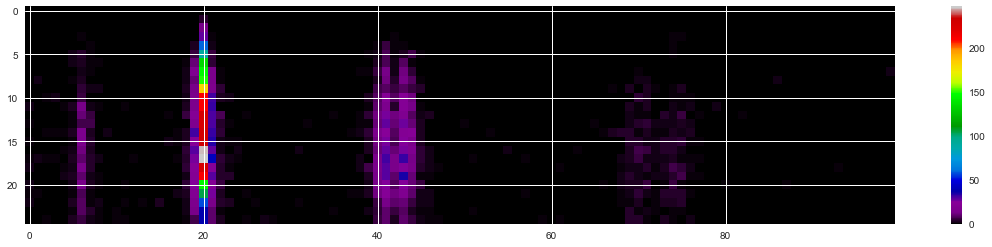

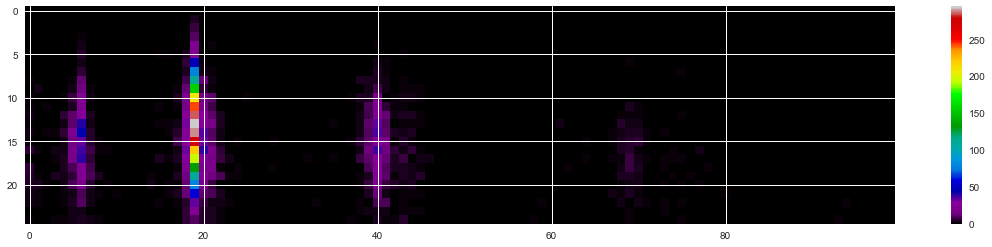

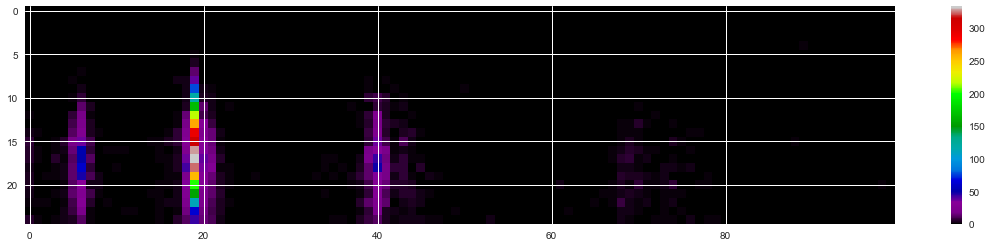

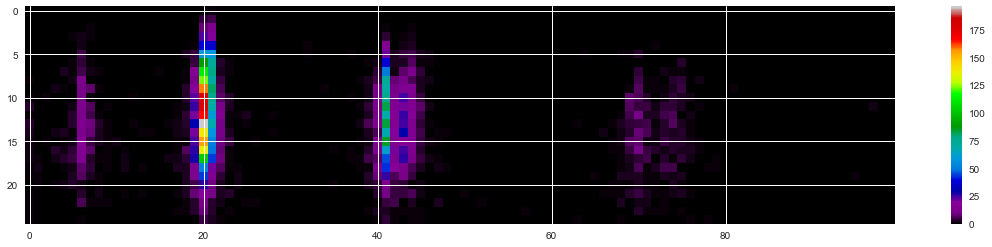

In [17]:
for idx in range(90,100):
    shade = unroll_cube(ecal[idx])
    plot_windowshade(shade.T[:,:100]) # Clip to 100, after that everything is tiny

### Exploring the dark regions of the image

In [18]:
import math

# Assuming cube has shape (x, x, y)
def graph_ecal_cube(cube, num_graphs=5):
    shade = unroll_cube(cube).T  # Shape: (y, x)
    slice_size = int(math.ceil(shade.shape[1] / num_graphs))
    for idx in range(num_graphs):
        plot_windowshade(shade[:, idx*slice_size:(idx+1)*slice_size])

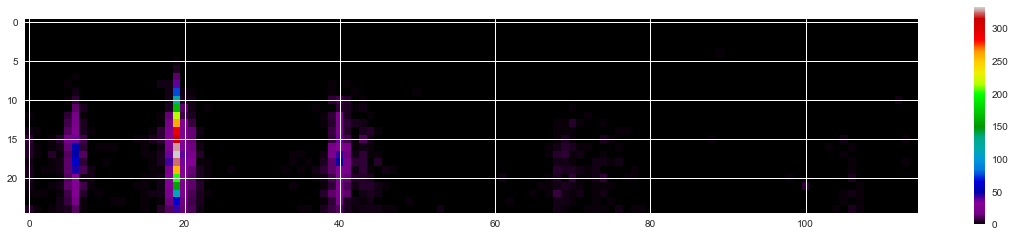

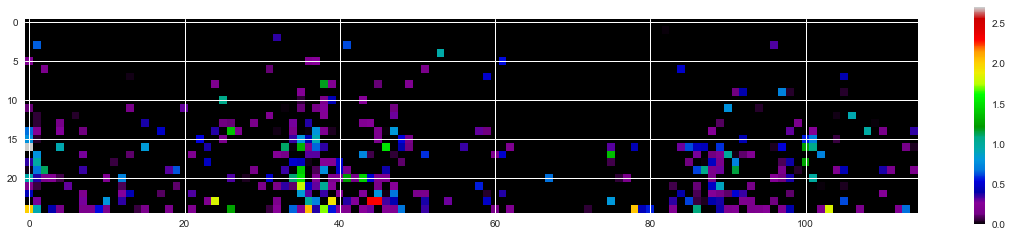

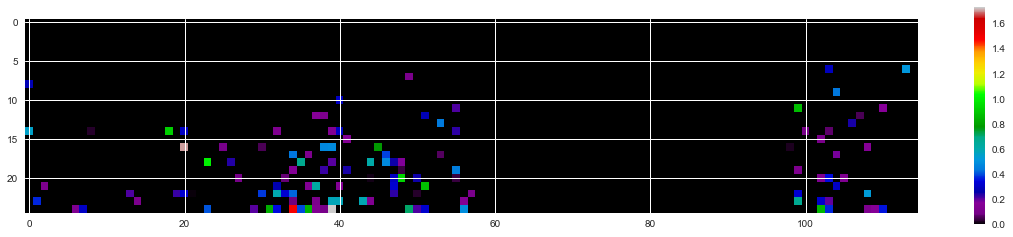

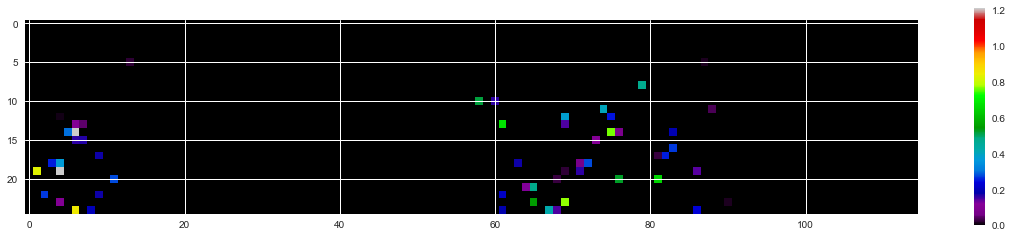

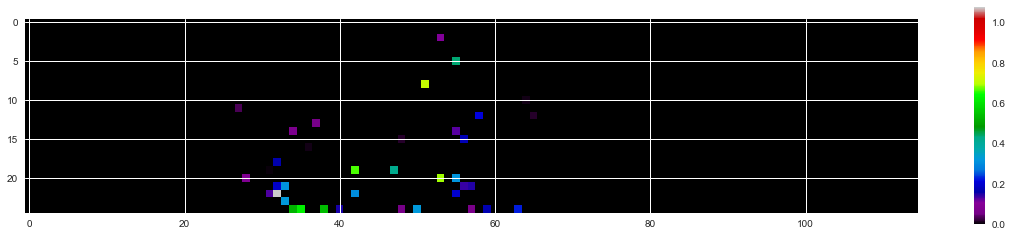

In [19]:
ecal_idx = 98
# These ecals are (24, 24, 25)
graph_ecal_cube(ecal[ecal_idx], num_graphs=5)

Interesting! Occasionally slashes of low energy all around. Definitely not just uniformly distributed noise.

Does this low energy stuff exist in the high energy slice?

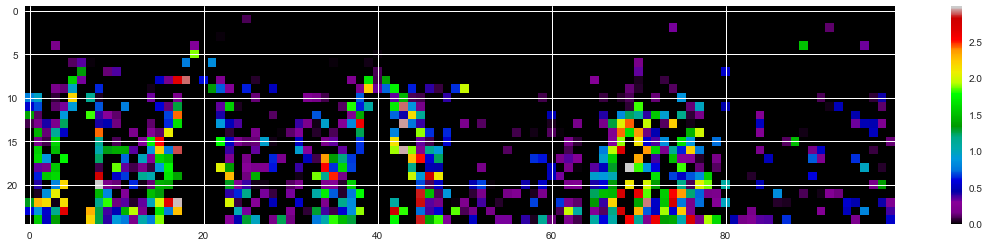

In [20]:
ecal_idx = 98
shade = unroll_cube(ecal[ecal_idx]).T  # shape is (25, 576)
shade[np.where(shade > 3)] = 0
plot_windowshade(shade[:, :100])

Sure does! I wonder if we'll need to make two models: one for high energy, and one for low energy.

### How different does it look if you use the DataLoader.batch_iter to cut out the zeros?

The 20-24 portion of each ecal slice is always exactly zero. The DataLoader iterator methods cut this superflous data out. Let's see how that affects the pictures.

In [23]:
data_loader.DataLoader?

In [21]:
# The returned ecal has shape (20, 20, 25)
dl = data_loader.DataLoader([100], test=True)
trunc_iter = dl.train_batch_iter(batch_size=1, num_epochs=1)
def next_trunc_ecal():
    trunc_ecal, _ = trunc_iter.next()
    return trunc_ecal[0]

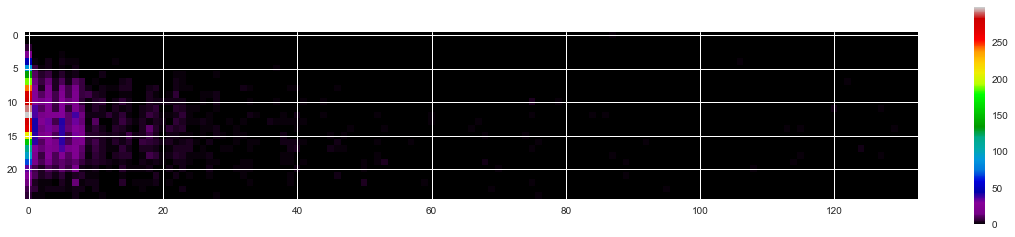

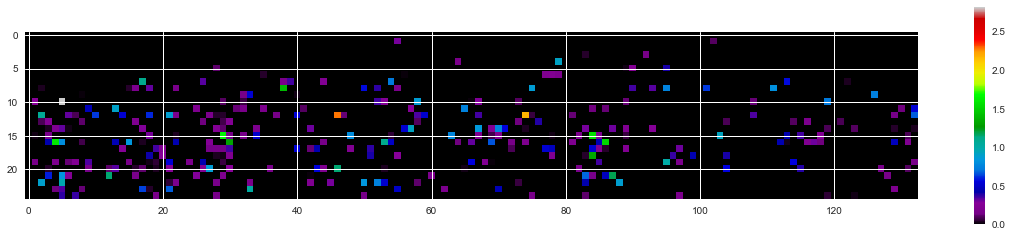

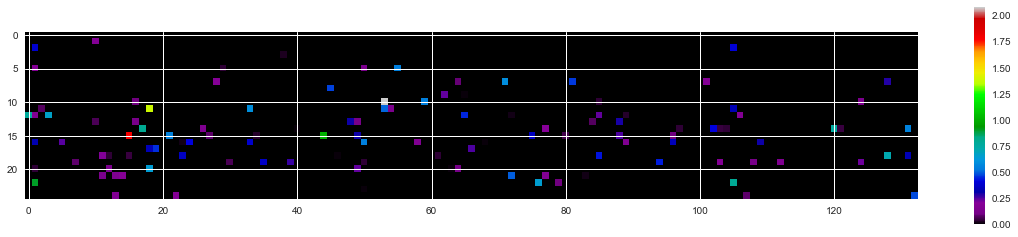

In [47]:
trunc_ecal = next_trunc_ecal()
graph_ecal_cube(trunc_ecal, num_graphs=3)

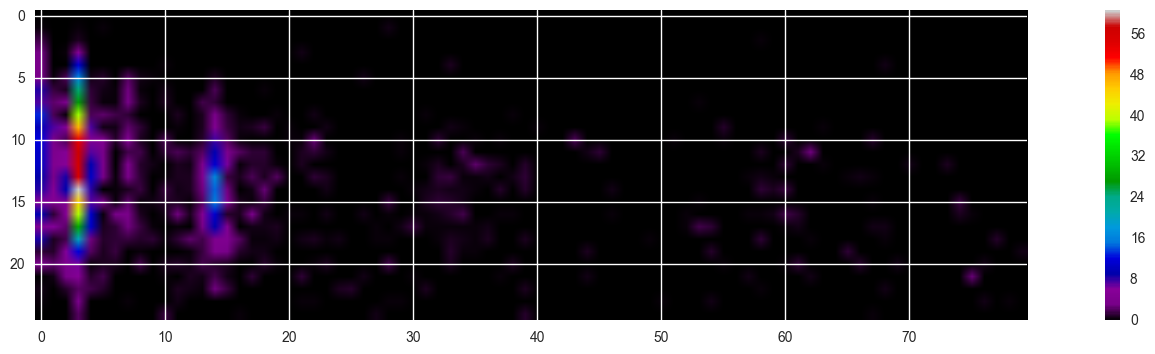

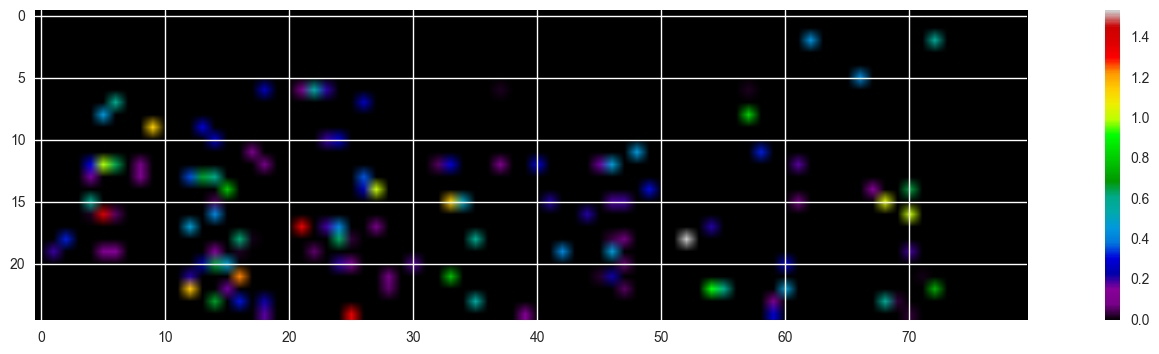

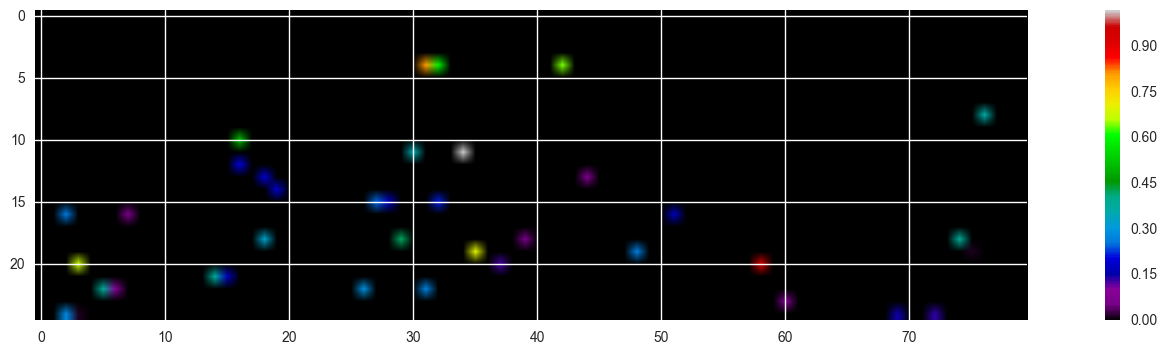

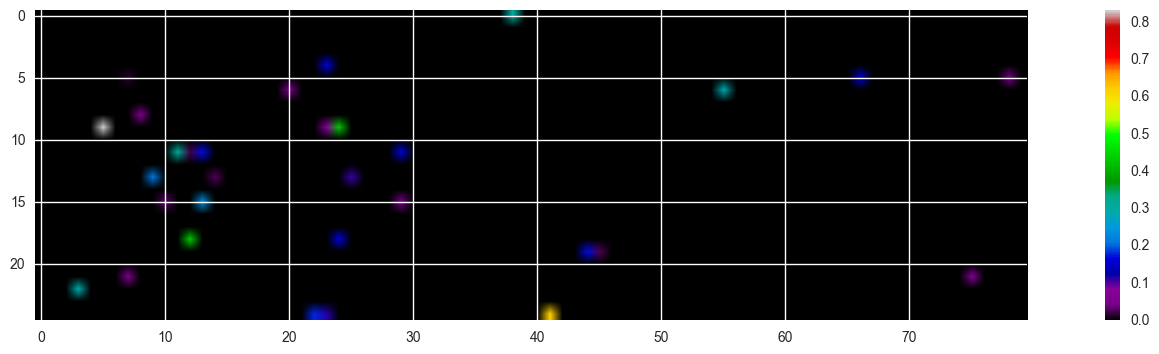

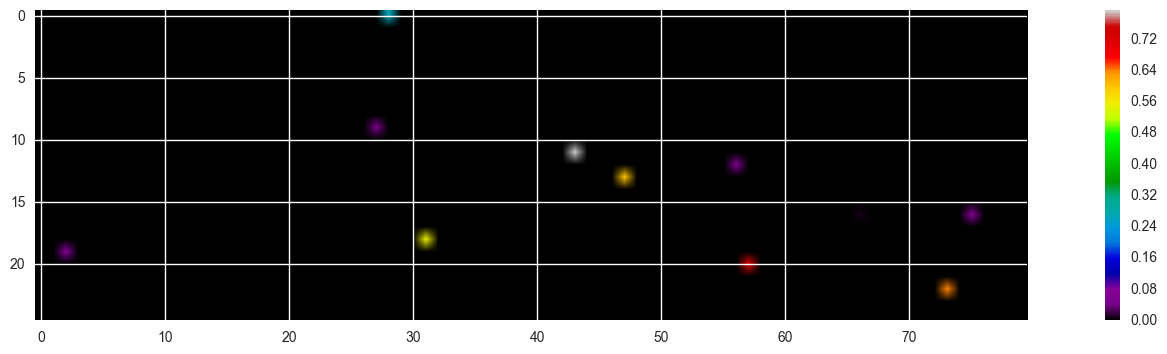

In [139]:
trunc_ecal = next_trunc_ecal()
graph_ecal_cube(trunc_ecal, num_graphs=5)